# Exploratory Data Analysis

In the following, I analyze the dataset underlying the ML model for scheduling standby drivers.
<br>
I want to clarify which variables are interrelated, how they are distributed and thus find out which ones are suitable for the model as features.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
from datetime import datetime, date 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
#import statsmodels.api as sm
#from statsmodels.tsa.stattools import adfuller

In [3]:
import platform
print(platform.python_version())

3.8.5


In [4]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


### Load and inspect the data:

In [5]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv') #, index_col=0)
df['date'] = pd.to_datetime(df['date'])

Ideally, the data is already in chronological order and the time stamps are equidistant in time series. This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.
<br>
This column is provided in string format. Let's convert it to the datetime64[ns] data type.

[Quelle](https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting/notebook)

In [6]:
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01 00:00:00,73,8154.000000,1700,90,4.000000,0.000000
1,1,2016-04-02 00:00:00,64,8526.000000,1700,90,70.000000,0.000000
2,2,2016-04-03 00:00:00,68,8088.000000,1700,90,0.000000,0.000000
3,3,2016-04-04 00:00:00,71,7044.000000,1700,90,0.000000,0.000000
4,4,2016-04-05 00:00:00,63,7236.000000,1700,90,0.000000,0.000000


* **date:** entry date
* **n_sick:** number of drivers called sick on duty
* **calls:** number of emergency calls
* **n_duty:** number of drivers on duty available
* **n_sby:** number of standby resources available
* **sby_need:** number of standbys, which are activated on a given day
* **dafted:** number of additional drivers needed due to not enough standbys

In [7]:
# Check time intervals
df = df.sort_values(by='date')
df['Time_Interval'] = df.date - df.date.shift(1)

df[['date', 'Time_Interval']].head()

,date,Time_Interval
0,2016-04-01,NaT
1,2016-04-02,1 days
2,2016-04-03,1 days
3,2016-04-04,1 days
4,2016-04-05,1 days


The data should be in chronological order and the timestamps should be equidistant in time series. 
<br>
&rarr; IT IS

In [8]:
# check if no date appears more than once
df.date.duplicated().sum()

0

Let's look at numerical summaries:

In [9]:
df.describe()

,Unnamed: 0,n_sick,calls,n_duty,n_sby,sby_need,dafted,Time_Interval
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000,1151
mean,575.500000,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938,1 days 00:00:00
std,332.698061,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089,0 days 00:00:00
min,0.000000,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000,1 days 00:00:00
25%,287.750000,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000,1 days 00:00:00
50%,575.500000,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000,1 days 00:00:00
75%,863.250000,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000,1 days 00:00:00
max,1151.000000,119.000000,11850.000000,1900.000000,90.0,555.000000,465.000000,1 days 00:00:00


At least 4074 calls were received during the period, maximum 11.850. On average, 7919.53 calls were received.
<br>
On average, 34.7 drivers are needed on standby. However, since the maximum is 555, it is worth looking for outliers here.

This also tells as that there are no negative values where there shouldn't be.

Check for NaN-values:

In [10]:
print(df.isnull().sum().sum())
print(df[df.isnull().any(axis=1)])


1
   Unnamed: 0       date  n_sick   calls  n_duty  n_sby  sby_need  dafted  \
0           0 2016-04-01      73  8154.0    1700     90       4.0     0.0   

  Time_Interval  
0           NaT  


Only NaN is in the first line of the new column --> so in the original data there are no NaN.

The following data types exist:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Unnamed: 0     1152 non-null   int64          
 1   date           1152 non-null   datetime64[ns] 
 2   n_sick         1152 non-null   int64          
 3   calls          1152 non-null   float64        
 4   n_duty         1152 non-null   int64          
 5   n_sby          1152 non-null   int64          
 6   sby_need       1152 non-null   float64        
 7   dafted         1152 non-null   float64        
 8   Time_Interval  1151 non-null   timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4), timedelta64[ns](1)
memory usage: 90.0 KB


So sehen die Were in verschiedenen Spalten aus:

In [12]:
df.n_duty.unique()

array([1700, 1800, 1900])

This means, there is only three options of drivers on duty. The values increase over time.

In [13]:
df.n_sby.unique()

array([90])

There are always 90 drivers on standby.

In [14]:
def min_max(data):
    print(data.min())
    print(data.max())

In [87]:
min_max(df.date)

2016-04-01 00:00:00
2019-05-27 00:00:00


In [23]:

# Checking for negative values
df.loc[df.n_sick < 0]
df.loc[df.calls < 0]
df.loc[df.n_duty < 0]
df.loc[df.n_sby < 0]
df.loc[df.sby_need < 0]
df.loc[df.dafted < 0]



,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,Time_Interval


The data covers a period of four years, from April 1st 2016 to May 27th 2019.

Correlation matrix between all the features we are examining and our y-variable:

In [16]:
corr = df.corr()

print(corr)

            Unnamed: 0    n_sick     calls    n_duty  n_sby  sby_need  \
Unnamed: 0    1.000000  0.495959  0.385679  0.927437    NaN  0.137543   
n_sick        0.495959  1.000000  0.155371  0.459501    NaN  0.022321   
calls         0.385679  0.155371  1.000000  0.364135    NaN  0.677468   
n_duty        0.927437  0.459501  0.364135  1.000000    NaN  0.090654   
n_sby              NaN       NaN       NaN       NaN    NaN       NaN   
sby_need      0.137543  0.022321  0.677468  0.090654    NaN  1.000000   
dafted        0.131938  0.016800  0.557340  0.084955    NaN  0.945168   

              dafted  
Unnamed: 0  0.131938  
n_sick      0.016800  
calls       0.557340  
n_duty      0.084955  
n_sby            NaN  
sby_need    0.945168  
dafted      1.000000  


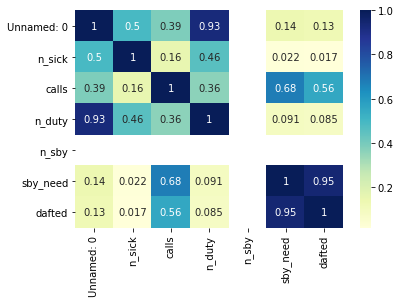

In [15]:
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


### Investigate graphically

Make pairplots to investigate data further and spot correlations:

<Figure size 432x288 with 0 Axes>

<Figure size 864x720 with 0 Axes>

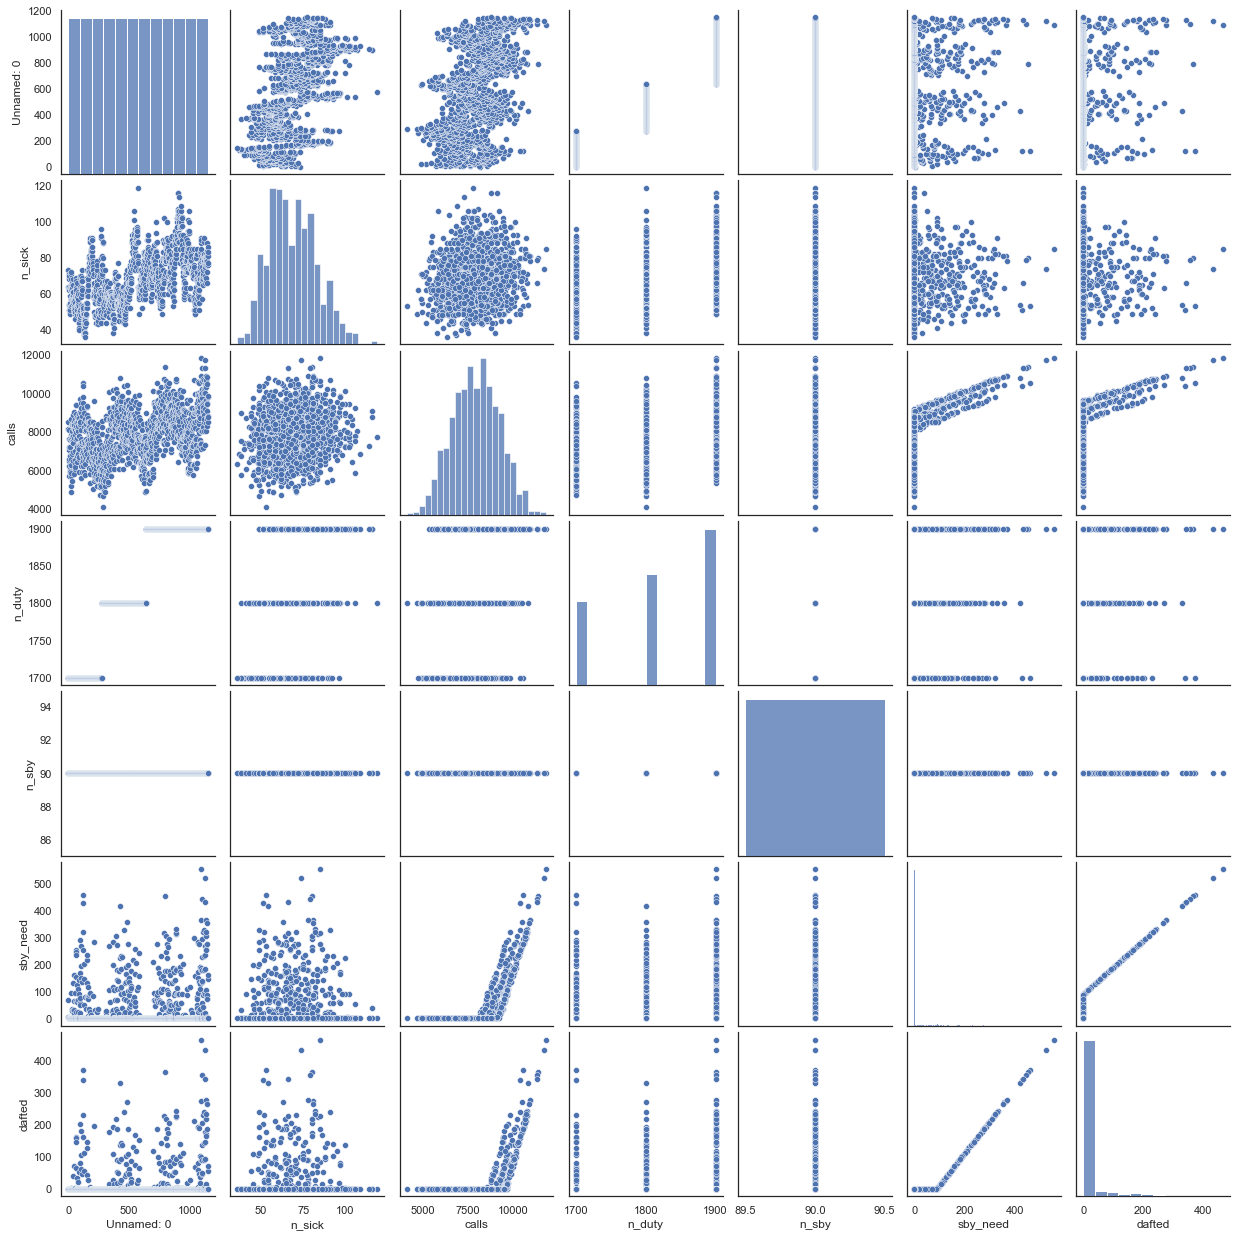

In [42]:
plt.clf()
plt.figure(figsize=(12,10))
sns.set_theme(style="white")

sns.pairplot(df)

plt.savefig("pairplot.svg")
plt.show()

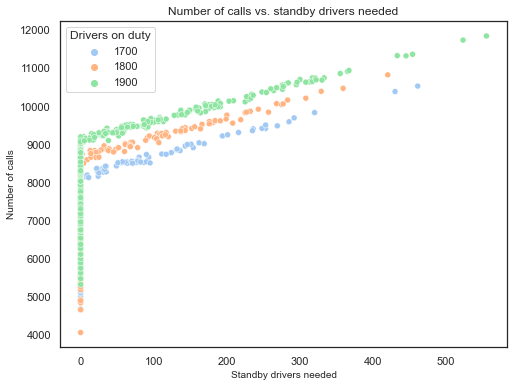

In [66]:
plt.figure(figsize=(8,6))
p = sns.scatterplot(x='sby_need', y='calls', hue='n_duty', data=df, palette='pastel')
p.set_xlabel("Standby drivers needed", fontsize = 10)
p.set_ylabel("Number of calls", fontsize = 10)
plt.legend(title='Drivers on duty', loc='upper left')
plt.title("Number of calls vs. standby drivers needed", fontsize = 12)
plt.savefig("calls_sby_need.svg")
plt.show()


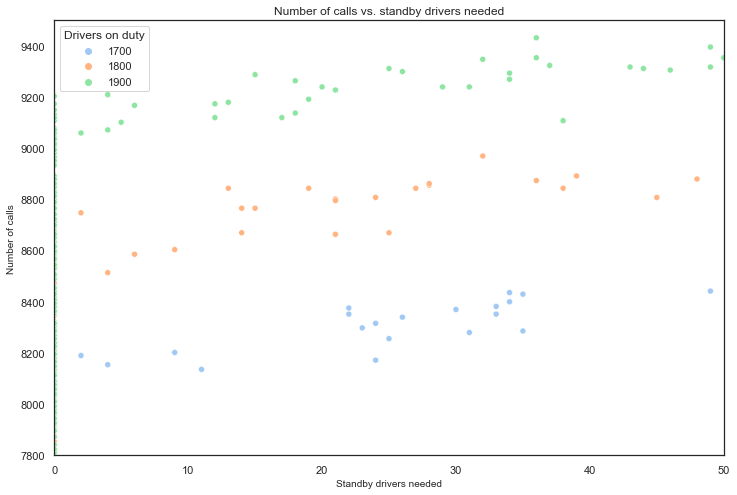

In [67]:
plt.figure(figsize=(12,8))
p = sns.scatterplot(x='sby_need', y='calls', hue='n_duty', data=df, palette='pastel')
p.set_xlabel("Standby drivers needed", fontsize = 10)
p.set_ylabel("Number of calls", fontsize = 10)
plt.axis([0, 50, 7800, 9500])
plt.legend(title='Drivers on duty', loc='upper left')
plt.title("Number of calls vs. standby drivers needed", fontsize = 12)
plt.show()



n_sick und calls sind saisonal, bei sby_need und calls sieht man, dass es erst ab 8000 calls Standby-Fahrer braucht.

The distribution of "sby_need" looks interesting, this is how the histogram looks in detail:

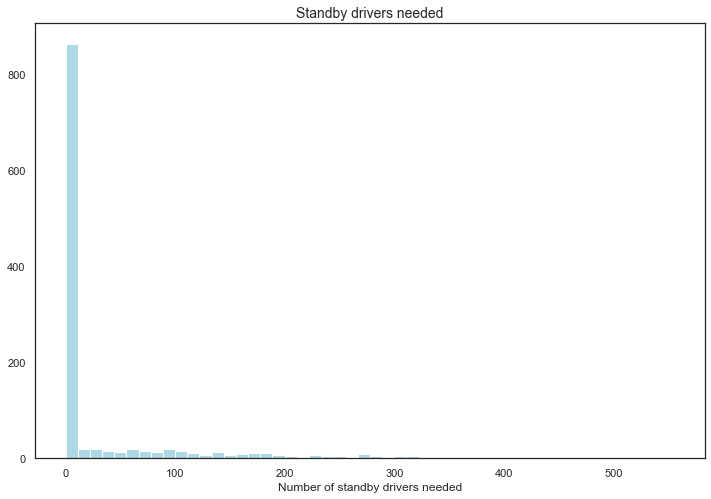

In [44]:
plt.figure(figsize=(12, 8))
plt.clf()
plt.hist(df.sby_need, bins=50, color='lightblue')
plt.title('Standby drivers needed', fontsize=14)
plt.xlabel('Number of standby drivers needed')
plt.show()

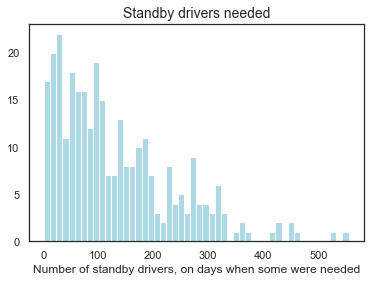

In [68]:
df_new = df[df.sby_need != 0]

plt.hist(df_new.sby_need, bins=50, color='lightblue')
plt.xlabel('Number of standby drivers, on days when some were needed')
plt.title('Standby drivers needed', fontsize=14)
plt.savefig("sby_need_hist.svg")
plt.show()

Standby drivers were not needed in nearly three-quarters of the cases. However, there are also individual cases in which several hundred were needed.
<br>
Another graphic will illustrate this.

Most of the time no standby drivers were needed, otherwise between 2 and 5. It could become problematic that there are numerous individual cases where hundreds were needed.

Visualize data over the years:

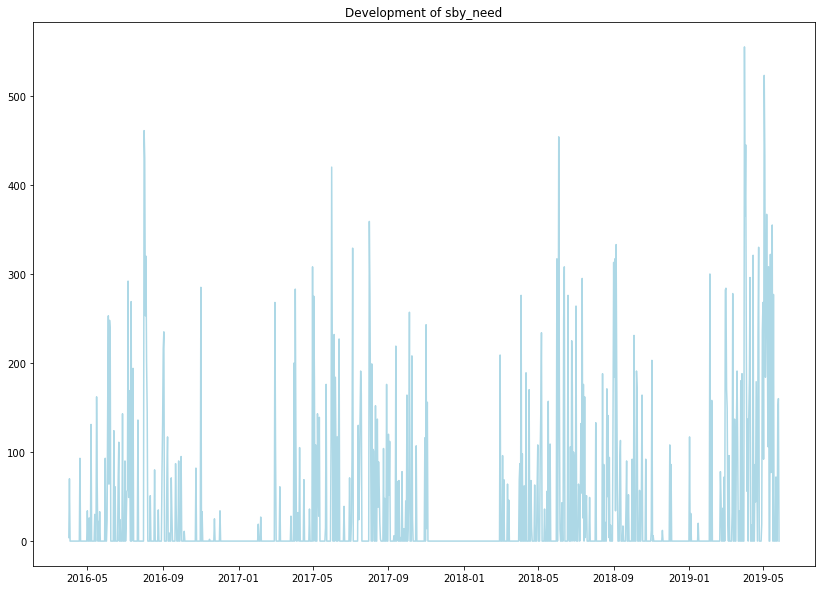

In [12]:
plt.figure(figsize=(14,10))
plt.plot(df.date, df.sby_need, color='lightblue')
#plt.xticks([204, 650, 900], ['19.4.2016', '16.5.2016', '4.6.2016'])
plt.title('Development of sby_need', fontsize=12)
plt.savefig("sby_need_plot.svg")
plt.show()

### Further Correlations

We observe that the number of drivers increases over the years. Is there a correlation with the number of calls?

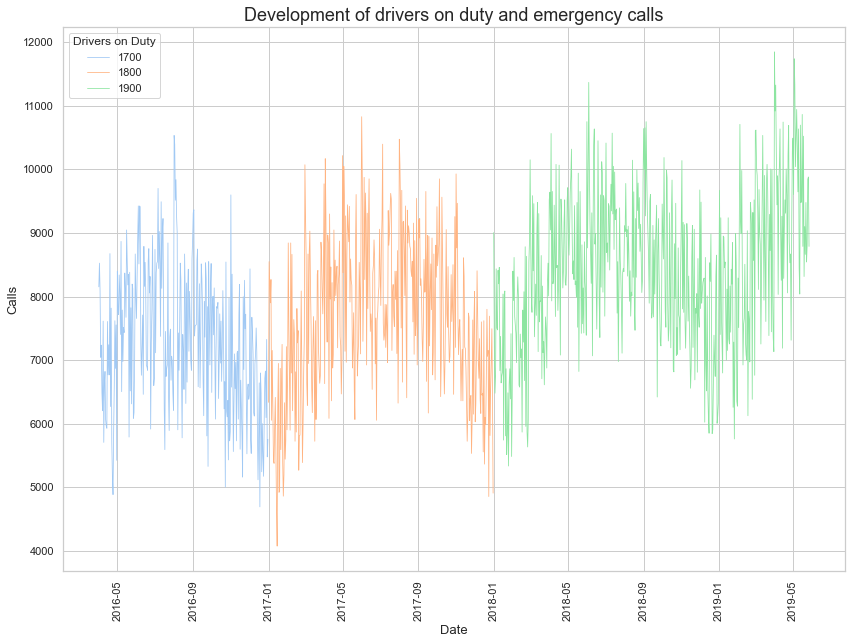

In [72]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.lineplot(x='date', y='calls', hue='n_duty', data=df, linewidth = 0.8, palette='pastel')
#plt.xticks([0, 275, 640, 1151], ['01.04.2016', '01.01.2017', '01.01.2018', '27.05.2019'])

plt.xticks(rotation=90)
plt.legend(labels=["1700","1800", "1900"], title = "Drivers on Duty")
plt.xlabel('Date', fontsize=13)
plt.ylabel('Calls', fontsize=13)
plt.title('Development of drivers on duty and emergency calls', fontsize=18)

plt.savefig("dev_n_duty_calls.svg")
plt.show()

The graph shows that the number of drivers on duty increases with the number of calls.

In [77]:
print(pearsonr(df.calls, df.n_duty)[0])

0.3641353611078072


According to Pearson's correlation coefficient r, the two variables are slightly positively correlated with a value of 0.36.

What about the number of calls and the number of drivers on sick leave?

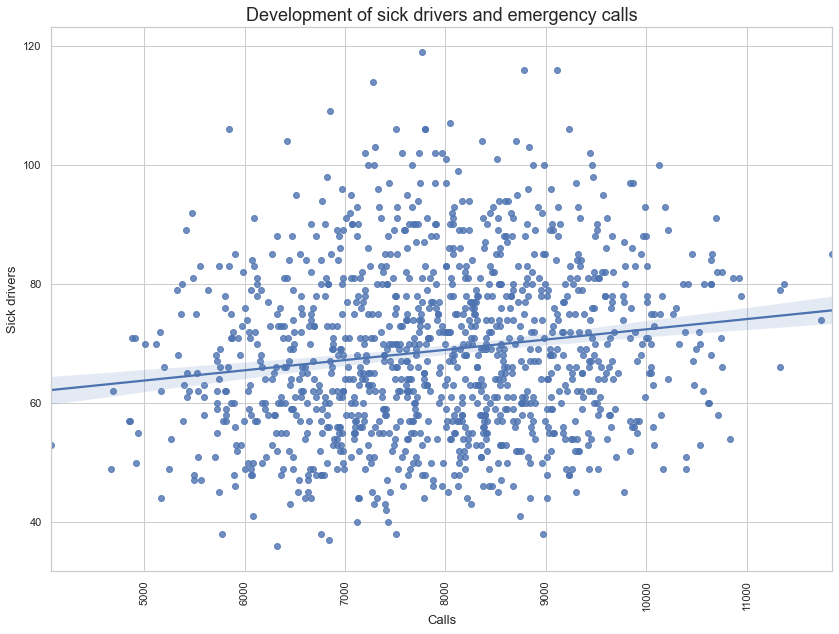

In [34]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.regplot(x='calls', y='n_sick', data=df)
plt.xticks(rotation=90)

plt.title('Development of sick drivers and emergency calls', fontsize=18)
plt.xlabel('Calls', fontsize=13)
plt.ylabel('Sick drivers', fontsize=13)

plt.show()

If the number of calls increases, the number of sick drivers slightly increases

In [35]:
print(pearsonr(df.calls, df.n_sick)[0])

0.15537086860280808


The variables are weakly positively correlated.

The pairplot above suggests a correlation between calls and drivers needed. Pearson's r confirms this:

In [36]:
print(pearsonr(df.calls, df.sby_need)[0])

0.677467517263761


The variables "n_sick" and "sby_need" are less related than thought:

In [37]:
print(pearsonr(df.n_sick, df.sby_need)[0])

0.02232140685865095


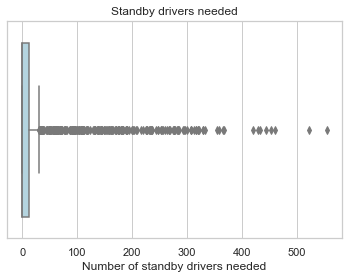

In [82]:
sns.boxplot(x='sby_need', data=df, color='lightblue')
plt.title('Standby drivers needed', fontsize=12)
plt.xlabel('Number of standby drivers needed', fontsize=12)
plt.savefig("sby_need_boxplot.svg")
plt.show()
